In [1]:
import os, json, sys,re,io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import fbprophet
from data_ingestor import *
from time_series import *

In [2]:
FILE_PATH = "C:\Dinesh\Personal\Learning\IBM-AI-Data-Scientist\Capstone-Part-1\Data\cs-train"
df = read_json_files(FILE_PATH)
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [29]:
df_clean = df.copy()
df_clean.drop(['customer_id'],axis=1,inplace=True)
df_clean = datatype_map(df_clean)
df_clean.head()

,country,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,28,489434,11,1.65,22064,17,2017,2017-11-28


C:\Users\DineshNaik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


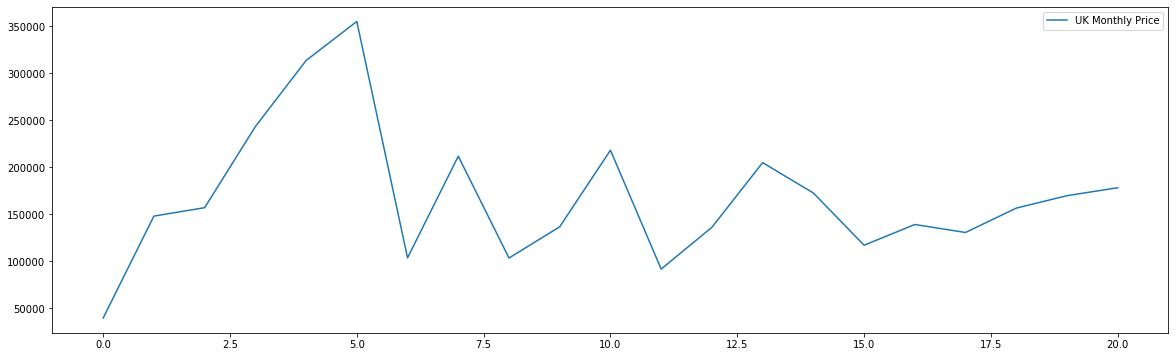

In [45]:
df_uk = df_clean[df_clean['country']=='United Kingdom']

df_uk['year_month'] = df_uk['year'].astype(str)+'-'+df_uk['month'].astype(str)
df_uk_inv_amt = df_uk.groupby(['year_month']).agg({'times_viewed':'sum','price':'sum',}).reset_index()
df_uk_inv_amt.sort_values('year_month',ascending=True)
df_uk_inv_amt['price'].plot(figsize=(20,6),label='UK Monthly Price')
plt.legend(loc='best')

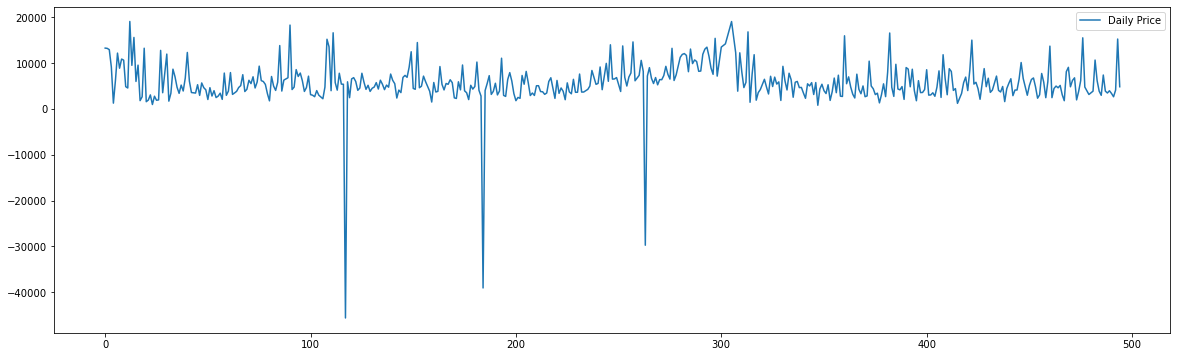

In [50]:
# checking stationarity of a time-series on a daily basis
df_day = df_uk.groupby(['invoice_date']).agg({'times_viewed':'sum', 'price':'sum', 'country':'first',}).reset_index()
df_day = df_day[df_day['price']<=20000]

df_day['price'].plot(figsize=(20,6),label='Daily Price') #Eliminate price outliner for > 20000
plt.legend(loc='best')

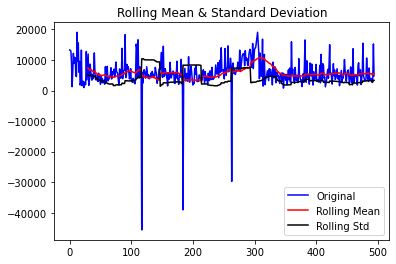

Result for Dickey-Fuller Test:
Test Statistic                 -19.453067
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    474.000000
Critical value(1%)              -3.444221
Critical value(5%)              -2.867657
Critical value(10%)             -2.570028
dtype: float64


C:\Users\DineshNaik\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [51]:
rol_day=30
get_stationarity(df_day['price'],rol_day)

C:\Users\DineshNaik\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


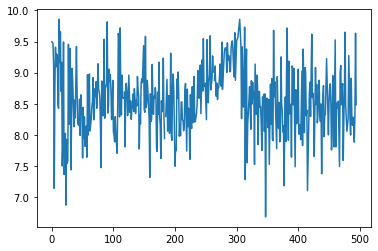

In [52]:
ts_log_UK = np.log(df_day['price'])
plt.plot(ts_log_UK)

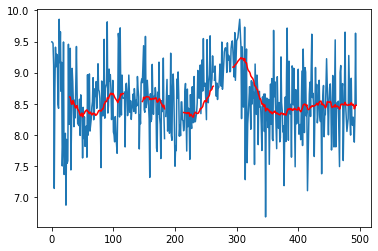

In [54]:
moving_avg_UK = ts_log_UK.rolling(30).mean()
plt.plot(ts_log_UK)
plt.plot(moving_avg_UK, color='red')

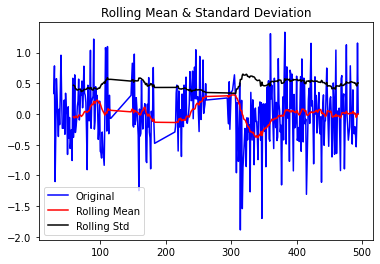

Result for Dickey-Fuller Test:
Test Statistic                -5.696994e+00
p-value                        7.832521e-07
#Lags Used                     5.000000e+00
Number of Observations Used    3.500000e+02
Critical value(1%)            -3.449173e+00
Critical value(5%)            -2.869833e+00
Critical value(10%)           -2.571188e+00
dtype: float64


In [55]:
ts_log_moving_avg_diff_UK = ts_log_UK - moving_avg_UK
rol_day=30
ts_log_moving_avg_diff_UK.dropna(inplace=True)
get_stationarity(ts_log_moving_avg_diff_UK,rol_day)

C:\Users\DineshNaik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


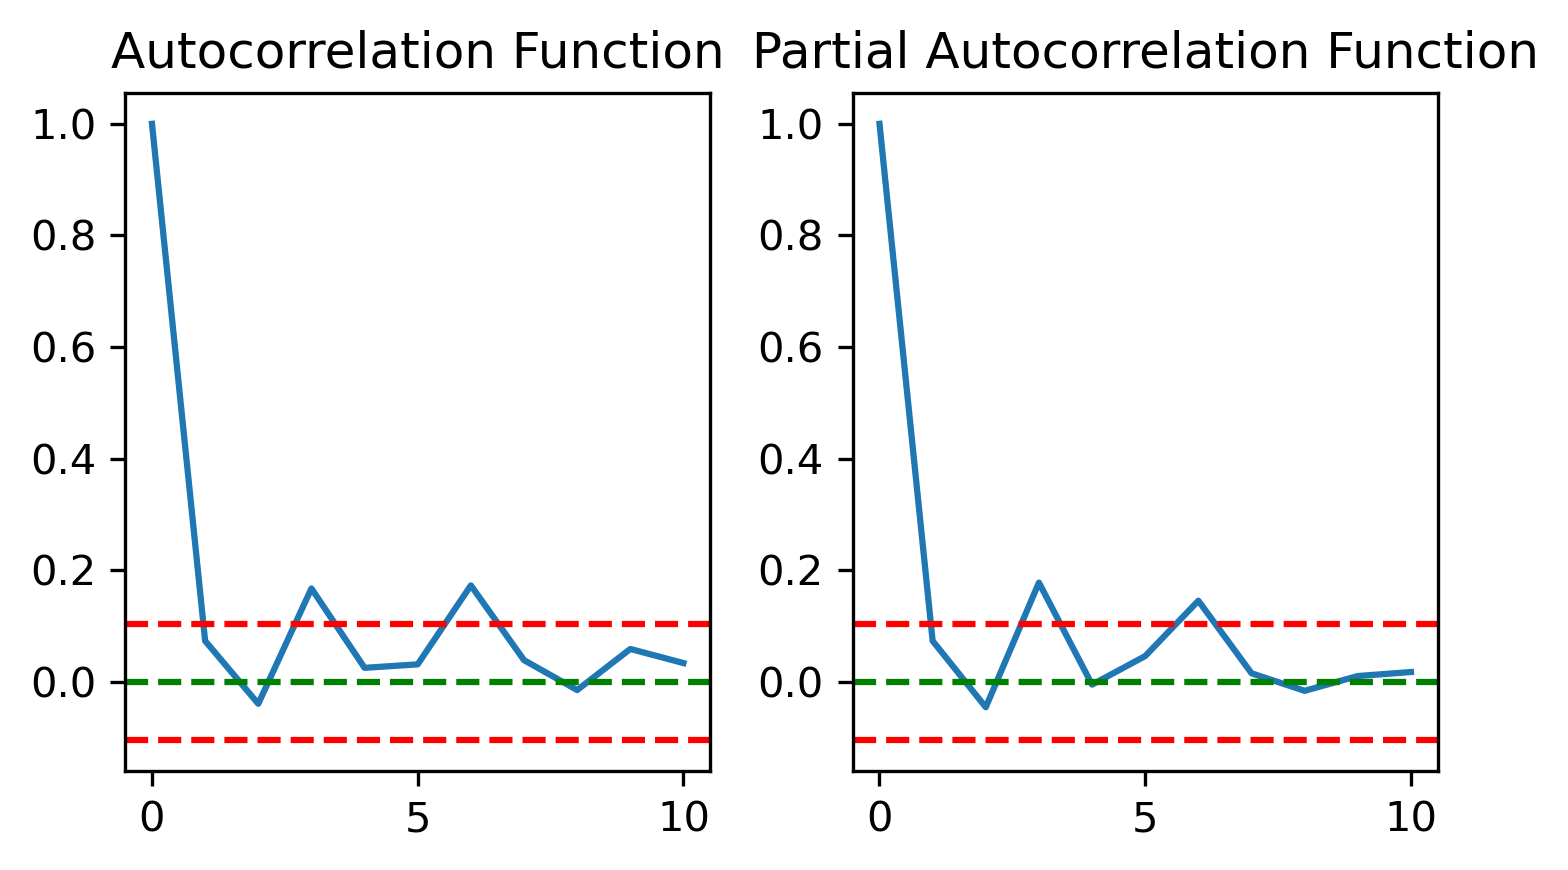

In [57]:
## Applying ACF and PACF 
get_ACF_PACF(df_day['price'],30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,8124.0,3994.0,14358.0,8124.0,8124.0,1166.0,1166.0,1166.0,1166.0,1166.0,1166.0,0.0,0.0,0.0,9291.0
1,2017-11-29,8033.0,2713.0,12666.0,8033.0,8033.0,-65.0,-65.0,-65.0,-65.0,-65.0,-65.0,0.0,0.0,0.0,7968.0
2,2017-11-30,7941.0,3739.0,13817.0,7941.0,7941.0,567.0,567.0,567.0,567.0,567.0,567.0,0.0,0.0,0.0,8508.0
3,2017-12-01,7850.0,2661.0,13237.0,7850.0,7850.0,217.0,217.0,217.0,217.0,217.0,217.0,0.0,0.0,0.0,8066.0
4,2017-12-02,7758.0,1830.0,12658.0,7758.0,7758.0,-854.0,-854.0,-854.0,-854.0,-854.0,-854.0,0.0,0.0,0.0,6904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,5747.0,-10.0,12493.0,2361.0,9133.0,747.0,747.0,747.0,747.0,747.0,747.0,0.0,0.0,0.0,6494.0
707,2019-11-05,5750.0,983.0,13819.0,2344.0,9178.0,1166.0,1166.0,1166.0,1166.0,1166.0,1166.0,0.0,0.0,0.0,6916.0
708,2019-11-06,5754.0,-287.0,12525.0,2257.0,9273.0,-65.0,-65.0,-65.0,-65.0,-65.0,-65.0,0.0,0.0,0.0,5689.0
709,2019-11-07,5757.0,126.0,12755.0,2185.0,9399.0,567.0,567.0,567.0,567.0,567.0,567.0,0.0,0.0,0.0,6324.0


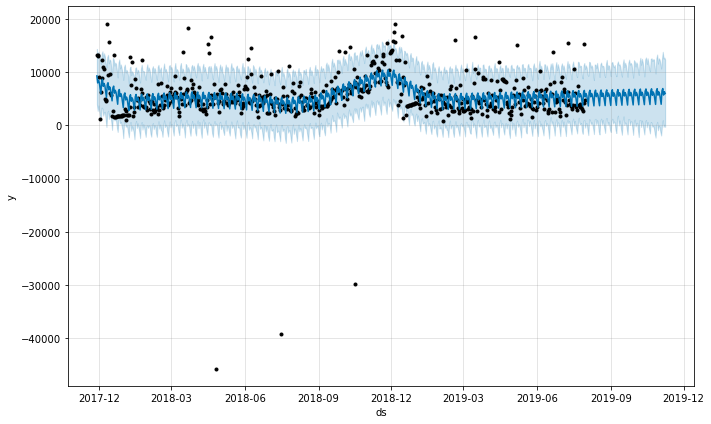

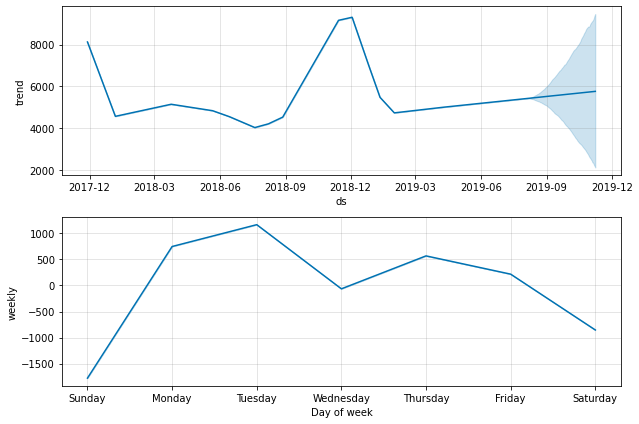

In [58]:
prophet_forecast(df_day,100,'1D')

In [59]:
m = Prophet()
ts = get_continuous(df_day,'1D')
df = pd.DataFrame()
df['ds'] = ts.index
df['y'] = ts.price.values
m.fit(df)
future = m.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [60]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
636,2019-08-26,5481.662790,-431.400743,11200.407559
637,2019-08-27,5924.288060,293.375501,11023.253507
638,2019-08-28,4682.953058,-748.408971,10081.640058
639,2019-08-29,5298.446326,-230.617254,10969.156991
640,2019-08-30,4937.535873,-822.527630,10259.337073


In [61]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='300 Days', period='100 Days', horizon='60 Days')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-11-13 00:00:00 and 2019-06-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-14,6591.787443,267.588979,13591.803410,10694.721,2018-11-13
1,2018-11-15,7481.314086,885.462659,13859.207609,10349.540,2018-11-13
2,2018-11-16,6870.454041,621.724484,13281.466799,8210.900,2018-11-13
3,2018-11-17,6060.131677,-1246.962661,12444.278245,8240.685,2018-11-13
4,2018-11-18,5509.015729,-838.452423,12010.239339,8270.470,2018-11-13


In [62]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,7.731003e+06,2780.468177,2382.942721,0.441715,0.357182,1.000000
1,7 days,7.765671e+06,2786.695282,2318.206366,0.396474,0.357182,1.000000
2,8 days,1.012983e+07,3182.739912,2518.402701,0.416762,0.359557,0.944444
3,9 days,1.099133e+07,3315.316900,2686.353238,0.429370,0.361696,0.944444
4,10 days,9.443468e+06,3073.022581,2471.296018,0.434280,0.361696,0.944444


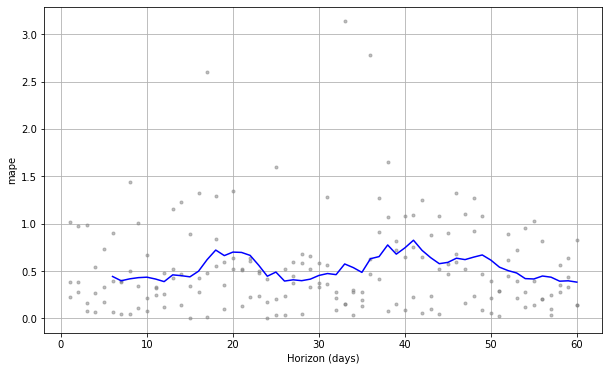

In [63]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.10)